# Zyfra Gold Recovery

# Introduction

The company Zyfra extracts gold concentrate from gold ore to make a profit. They would like to predict how much gold concentrate will be yielded from gold ore, optimizing their gold production. They have data collected from every stage of the gold extraction process. They have provided a training set, a test set, and a complete dataset. The complete dataset contains all of the observations, and all of the features/targets, even those calculated after extraction. The training set contains a subset of this data meant to train the prediction model. The test set, however, contains only the features that would be available to the company at the start of the extraction process, and therefore has fewer features and zero target data. This test set is important because this contains the data that the company wishes to make predictions off of.

A regression model will need to be trained to make numerical predictions. We will try out linear regression and random forest regression models. I will skip decision tree regression as random forest tends to be more accurate. The metric for success will be symmetric mean absolute error (sMAPE), based on the predicted gold recovery vs the actual gold recovery. I will use the trained models to predict rougher concentrate recovery and final concentrate recovery, calculate sMAPE for each, and combine the two scores for our final performance score. Both linear and random forest regression models are able to predict multiple targets from a single model. 

First I will explore preprocess the data, verifying that recovery was calculated correctly and comparing the training set with the test set. Missing values will need to be dealt with, and targets selected. I will keep a few extra columns in my target dataframe so as to keep the data for later exploration. Then I will compare the concentrations of each of the metals at different stages and figure out if there are any observations I should drop, and compare feed size distributions between the training set and test set. Finally I will train models, calculate combined sMAPE scores, and use the better-scoring model as our final model, training the model on our full training set and then finding final sMAPE on the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error

from joblib import dump

# Preprocessing

In [2]:
try:
    train = pd.read_csv('gold_recovery_train.csv')
except:
    train = pd.read_csv('/datasets/gold_recovery_train.csv')
    
try:    
    test = pd.read_csv('gold_recovery_test.csv')
except:
    test = pd.read_csv('/datasets/gold_recovery_test.csv')
    
try:
    full = pd.read_csv('gold_recovery_full.csv')
except:
    full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


I observe that the full and training datasets contain 87 columns while the test set contains only 53

In [7]:
full.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


## Verify recovery

$ (1)\ recovery = {C*(F-T) \over F*(C-T)} * 100\% $

In [8]:
def calc_recov(C, F, T):
    
    """
    This function calculates gold recovery.
    
    To calculate rougher recovery, this function takes three series as inputs:
    - C = rougher.output.concentrate_au
    - F = rougher.input.feed_au
    - T = rougher.output.tail_au
        and returns the percentage recovery of gold concentrate after the roughing stage.
    
    To calculate final recovery, this function takes three measurements as inputs:
    - C = final.output.concentrate_au
    - F = rougher.output.concentrate_au
    - T = final.tail_au
        and returns the percentage recovery of gold concentrate after the final purification stage.
    """
    
    recovery = (C*(F-T)) / (F*(C-T)) * 100
    
    return recovery

I want to calculate recovery for a row in the full dataset using my function to ensure that it works correctly, and that the values make sense.

In [9]:
# I need to drop nans before I can calculate mean absolute error, I'd rather make a df copy for now
train_cut = train.dropna(subset=['rougher.output.recovery', 'rougher.output.concentrate_au', 'rougher.input.feed_au', \
                                 'rougher.output.tail_au']) 

In [10]:
recov = train_cut['rougher.output.recovery']
pred_recov = calc_recov(train_cut['rougher.output.concentrate_au'], train_cut['rougher.input.feed_au'], train_cut['rougher.output.tail_au'])
mean_absolute_error(recov, pred_recov)

9.303415616264301e-15

Our recovery equation matches the recovery measurements exactly.

## Compare test set and training set

Let's check out the differences in columns between the training set and test set. The training set has more columns, so we should look at the columns that the test set is lacking.

In [11]:
test_columns = test.columns

In [12]:
drop_columns = train.drop(test_columns, axis=1)
drop_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                                16794 non-null  float64


Looks like the values missing from the test set are all outputs and calculations, which is data that would not be available at the start of extraction. This set mimics the data that Zyfra would have at the time of real-world prediction. From this list, we should choose which data we would like to predict.

## Preprocess datasets

### Training set

I will trim the training dataset down to the features and targets that I need, then drop nans at this point. I will split this table into training features and training targets. Later I will deal with the test set, dropping nans and getting targets from the full dataset.

According to the company - observations in the datasets come in order of time, and adjacent observations tend to be similar. Even though I intend to train models later via cross-validation, I think it would be a good idea to shuffle the data once the rest of preprocessing is done. The linear regression shouldn't be affected, but the random forest model may be.

In [13]:
targets = ['final.output.concentrate_au', 'final.output.tail_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au', 'rougher.output.recovery', 'final.output.recovery']

In [14]:
drop_columns.drop(targets, axis=1, inplace=True)
trim_train = train.drop(drop_columns.columns, axis=1)

In [15]:
trim_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 59 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        16860 non-null  object 
 1   final.output.concentrate_au                 16789 non-null  float64
 2   final.output.recovery                       15339 non-null  float64
 3   final.output.tail_au                        16794 non-null  float64
 4   primary_cleaner.input.sulfate               15553 non-null  float64
 5   primary_cleaner.input.depressant            15598 non-null  float64
 6   primary_cleaner.input.feed_size             16860 non-null  float64
 7   primary_cleaner.input.xanthate              15875 non-null  float64
 8   primary_cleaner.state.floatbank8_a_air      16820 non-null  float64
 9   primary_cleaner.state.floatbank8_a_level    16827 non-null  float64
 10  primary_cl

I need to remove nans so that I can run a regression model and calculate metrics. I could quickly fill missing values with the medians of their respective columns, but because the data is too complex to be easily understood, I don't want to do this and potentially mess up the data. Instead I will drop all observations with nans and hopefully most of the observations will remain.

In [16]:
print("Shape of train:", train.shape)
trim_train = trim_train.dropna()
print("Shape of trim_train:", trim_train.shape)

Shape of train: (16860, 87)
Shape of trim_train: (12679, 59)


The lengths of our new training and test sets seem acceptable. Let's briefly check for duplicate observations.

In [17]:
print(trim_train.duplicated().sum())

0


No duplicates.

Let's split the training set into features and targets.

In [18]:
target_train = trim_train[targets]
features_train = trim_train.drop(targets, axis=1).drop('date', axis=1)

Let's shuffle this data, using the same random state for each.

In [19]:
target_train = target_train.sample(frac=1, random_state=0)
features_train = features_train.sample(frac=1, random_state=0)

In [20]:
target_train.head(2)

,final.output.concentrate_au,final.output.tail_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery,final.output.recovery
10839,46.952644,2.742145,20.636330,1.443685,86.642056,67.029557
1484,43.398133,2.940562,19.877711,1.994857,83.328287,67.683848


In [21]:
features_train.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
10839,141.113187,5.921466,6.42,0.487425,1400.295401,-500.698994,1399.696865,-499.718060,1396.762131,-499.946180,...,16.028194,-501.055301,11.939871,-400.101071,16.040760,-500.358387,12.004880,-500.062909,15.023645,-500.255691
1484,128.832766,12.004063,7.40,0.893393,1601.128113,-400.489354,1602.468636,-401.175731,1598.154883,-401.100941,...,11.985771,-499.690481,11.927049,-500.482506,12.026011,-500.183876,9.997684,-500.108684,19.971137,-500.586422


Done. Indexes match positions.

Some groups of features share scales - others do not. Concentrations of materials are on vastly different scales than air volume and fluid levels. Some standardization may be needed. I am going to run my models without standardizing and, if needed, return later to try my models with standardizing.

### Collect targets for test set

I will perform similar preprocessing on the test set, making similar decisions, as I did for the training set.

The test set does not come with target values, as the test set represents the data that will be available to the company before the extraction process. I want to be able to test the performance of the models by having a target available to me for comparison, if possible. I will create an extra dataset that contains the full data for the test observations, then I can collect the target values into a series for later comparison with the predictions.

In [22]:
print(test.date.duplicated().sum())
print(full.date.duplicated().sum())

0
0


The dates are unique for the test and the full datasets.

In [23]:
test_full = full[full.date.isin(test.date)]
print(test_full.shape)
test_full_trimmed = test_full.dropna()
display(test_full_trimmed.shape)

(5856, 87)


(5077, 87)

Again, the drop in observations seems acceptable.

In [24]:
features_test = test_full_trimmed.drop('date', axis=1).drop(drop_columns.columns, axis=1).drop(targets, axis=1).reset_index(drop=True)
target_test = test_full_trimmed[targets].reset_index(drop=True)

Let's again shuffle the observations.

In [25]:
features_test = features_test.sample(frac=1, random_state=0)
target_test = target_test.sample(frac=1, random_state=0)

In [26]:
features_test.head(2)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
1066,155.507562,5.494756,7.45,0.697923,1612.572502,-500.379302,1697.824512,-499.370561,1701.563958,-500.799583,...,20.029042,-499.994998,17.065673,-500.620165,16.992510,-498.418438,13.999109,-499.398506,25.020453,-499.265078
1984,186.136041,8.077669,7.56,1.006578,1499.112950,-500.235282,1496.126482,-500.133917,1499.787758,-500.489865,...,17.999048,-500.059243,16.021223,-499.560018,17.691335,-499.859533,11.983882,-499.987108,21.299412,-499.454885


In [27]:
target_test.head(2)

,final.output.concentrate_au,final.output.tail_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery,final.output.recovery
1066,44.759348,2.738757,21.167898,1.480976,92.059299,78.188705
1984,44.286161,3.549825,21.508549,2.266078,87.186574,71.249294


I have visually verified that the features and the targets match indexes.

# Analyze Data

## Check concentrations of metals

Let's see how the concentrations of the metals vary with stage of extraction. I will use the full dataset for this. I predict that the concentration of gold will increase, while the concentrations of silver and lead will decrease.

In [28]:
def metals_eda(metal):
    
    """
    This function takes a string as input that represents the metal I wish to evaluate concentration distributions for. 
    
    For each metal I want to look at both the distributions for concentrations for the concentrates and the tails, 
        in the form of boxplots ordered from raw feed to final stage. 
    """
    
    conc_cols = ['rougher.input.feed_', 'rougher.output.concentrate_', 'primary_cleaner.output.concentrate_', \
                 'final.output.concentrate_']
    conc_cols = [column + metal for column in conc_cols]
    
    tail_cols = ['rougher.input.feed_', 'rougher.output.tail_', 'primary_cleaner.output.tail_', \
                 'secondary_cleaner.output.tail_', 'final.output.tail_']
    tail_cols = [column + metal for column in tail_cols]
    
    plt.figure(figsize=(14,4))
    sns.boxplot(full[conc_cols])
    plt.title(f"Concentration of concentrate at each stage for {metal.capitalize()}")
    
    plt.figure(figsize=(14,4))
    sns.boxplot(full[tail_cols])
    plt.title(f"Concentration of tail at each stage for {metal.capitalize()}")

Let's check gold first (Au).

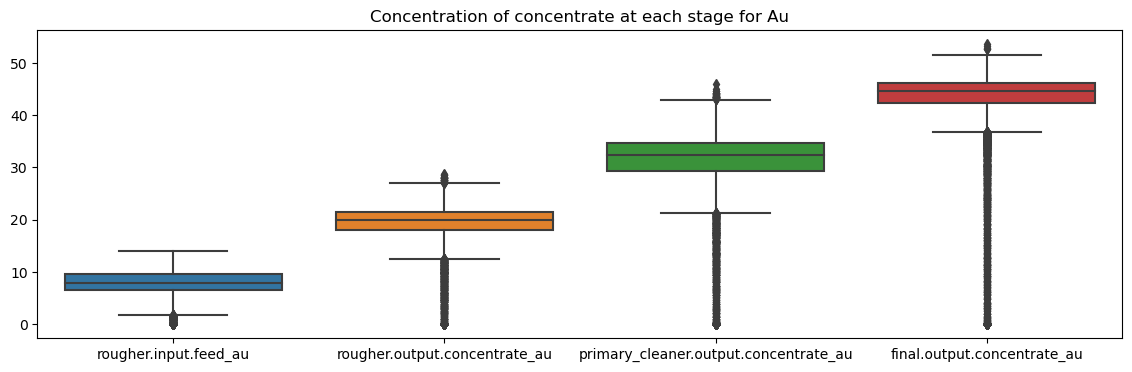

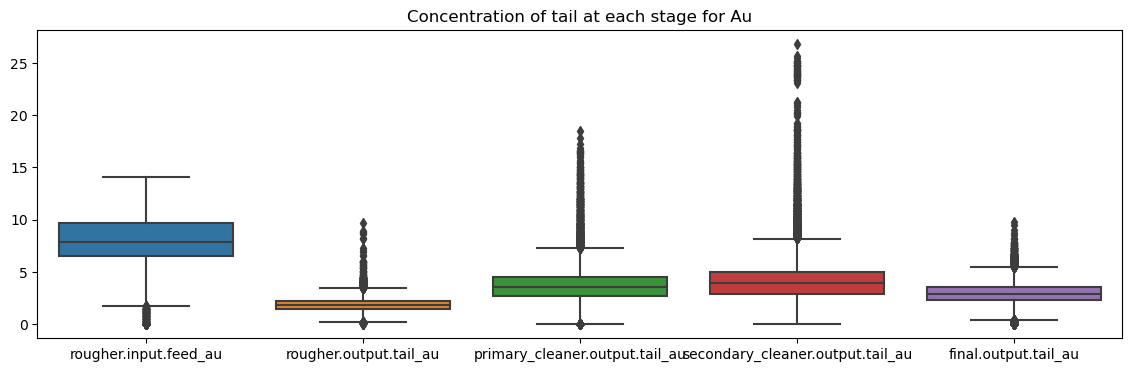

In [29]:
metals_eda('au')

Excellent - as expected, the concentration of gold concentrate increases through the stages of the extraction process. The concentration of gold in the tails stays fairly low throughout the process, which is good, because ideally, there would be zero gold in the tails for the gold extraction process. The concentration of gold starts at around 10 and finishes at nearly 50 by the end of the process. There seem to be a number of outliers where final gold concentration is low in concentrate but high in the tails, which is far from ideal.

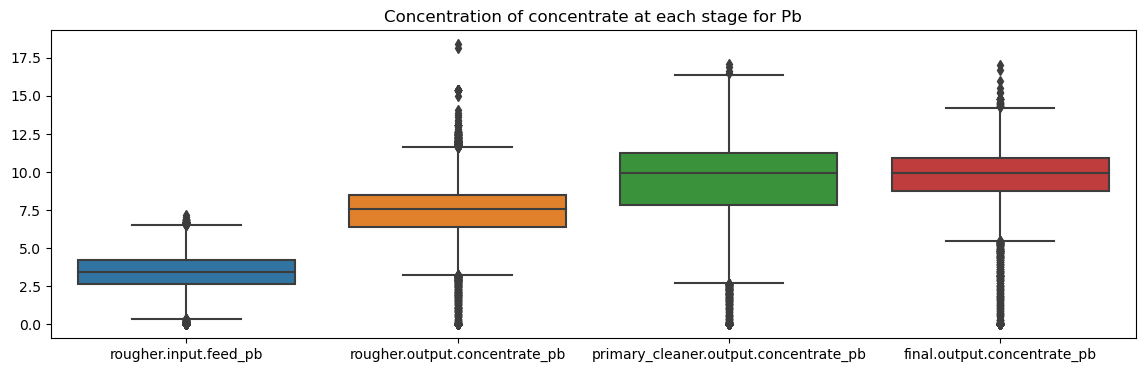

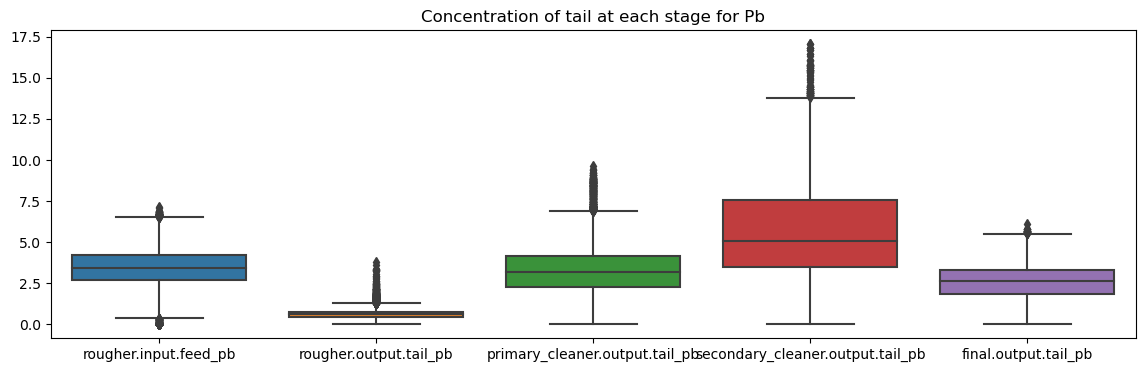

In [30]:
metals_eda('pb')

The concentration of lead starts low at around 3 but rises to around 10 by the end, which is still much less than the gold. The tail concentration fluctuates a bit but stays in the same general range throughout the process. 

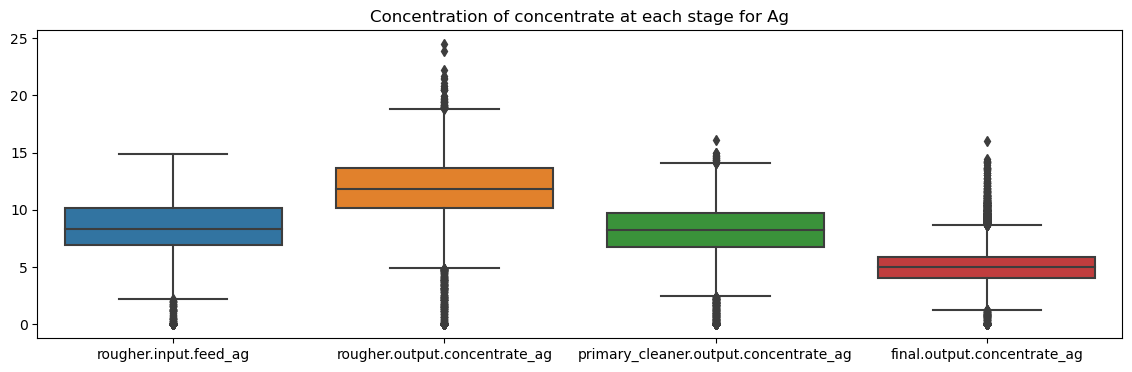

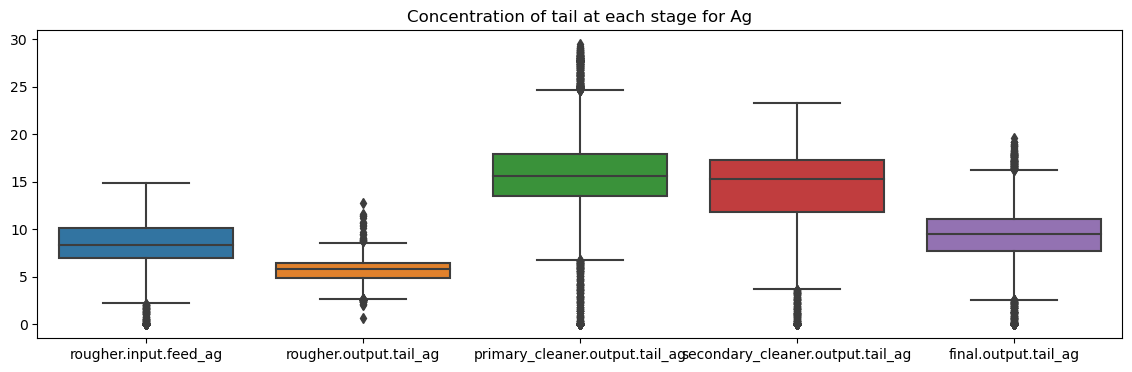

In [31]:
metals_eda('ag')

Silver concentration in the concentrate rises after the rougher stage but ultimately is lower than its starting concentration by the end of the process. There is a fairly high concentration of silver in the tails at each stage. The purification process seems to do a better job at reducing the concentration of silver than it does lead.

## Remove flawed observations

I want to see what happens to the length of the training and test datasets if I remove observations where the final concentration of gold is lower than or equal to the concentration of gold in the input feed, as this should not happen in a gold extraction process. This relationship should be extremely uncommon. Below I will write a function that will allow me to compare these values and edit the dataframes, along with allowing me to compare any other values I wish.

In [32]:
def trim_rows(features_df, target_df, features_col, target_col, greater=True):
    
    """
    This function trims rows from a pair of dataframes (training or testing sets) based on a certain measurement 
        from one dataframe being greater or less than the other. 
    
    Takes each of the two dataframes as input, then the columns that I wish to compare. The "greater" toggle is set to True
        but can be set to False to change the direction of the comparison.
    
    The function prints the original length and the new length, and returns the two dataframes as a tuple.
    """
    
    print("Length of original dataframes:", features_df.shape[0])
    
    if greater:
        bad_rows = features_df[features_df[features_col] >= target_df[target_col]].index
    else:
        bad_rows = features_df[features_df[features_col] <= target_df[target_col]].index

    features_df = features_df.drop(bad_rows)
    target_df = target_df.drop(bad_rows)
     
    print("Length of trimmed dataframes:", features_df.shape[0])
    
    return features_df, target_df

Let's first trim down the training set, removing observations where the concentration of gold at any of the advanced stages is the same as or less than the original concentration.

In [33]:
features_train, target_train = trim_rows(features_train, target_train, 'rougher.input.feed_au', 'rougher.output.concentrate_au')

Length of original dataframes: 12679
Length of trimmed dataframes: 12462


In [34]:
features_train, target_train = trim_rows(features_train, target_train, 'rougher.input.feed_au', 'final.output.concentrate_au')

Length of original dataframes: 12462
Length of trimmed dataframes: 12425


About 400 flawed observations were removed. Now let's do the same for the test set.

In [35]:
features_test, target_test = trim_rows(features_test, target_test, 'rougher.input.feed_au', 'rougher.output.concentrate_au')

Length of original dataframes: 5077
Length of trimmed dataframes: 4981


In [36]:
features_test, target_test = trim_rows(features_test, target_test, 'rougher.input.feed_au', 'final.output.concentrate_au')

Length of original dataframes: 4981
Length of trimmed dataframes: 4969


About 100 flawed observations were removed.

I do not have any strong feelings towards the relationships between the concentrations of silver or lead at different stages of the extraction process. Based on the boxplots it seems that the concentration of silver rises after the rougher stage but falls after the purification stages, and that the concentration of lead increases throughout the extraction process. Not too many rows were removed based on the gold concentration values, but we now at least know that our model will not be affected by these obvious anomalies.

## Check feed size distributions

Next we should compare the feed particle size between the training set and the test set to ensure that the distributions are similar.

<Axes: title={'center': 'Feed size in train vs test sets'}>

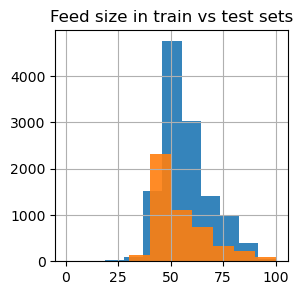

In [37]:
plt.figure(figsize=(3,3))
plt.title('Feed size in train vs test sets')

mask = 'rougher.input.feed_size'
features_train[mask][features_train[mask] <= features_train[mask].quantile(0.99)].hist(alpha=0.9)
features_test[mask][features_test[mask] <= features_test[mask].quantile(0.99)].hist(alpha=0.9)

Distributions are very similar. There are some much higher outliers which I omitted from the histogram. Both distributions are relatively normal. We should be able to evaluate the model well.

## Complete preprocessing

Now that all other preprocessing steps have been completed and training/testing dataframes have been finalized, I will reset the indexes.

In [38]:
features_train = features_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

# Build Models

Time to build the regression the models. I will try out a linear regression model and a random forest regressor model, and score them using cross-validation. I'll evaluate performance based on symmetric mean absolute percent error (sMAPE), select the model with the highest score, and test it on the test set to yield a final sMAPE score. 

## Calculate sMAPE

Writing functions to calculate sMAPE and to combine the rougher and final sMAPE scores into a final score.

In [39]:
def calc_smape(actual, pred):
    
    """
    This function takes a series of answers and of predictions, and calculates symmetric mean absolute percentage error (sMAPE).
        It returns the sMAPE value.
    """
    
    N = len(actual)
    sum = 0
    for i in range(N):
        numerator = abs(actual[i] - pred[i]) * 100
        denominator = (abs(actual[i]) + abs(pred[i])) / 2
        sum += (numerator/denominator)
    smape = sum / N
    
    return smape

In [40]:
def combine_smapes(rougher, final):
    
    """
    Calculates a combined sMAPE score using the rougher concentrate sMAPE and final concentrate sMAPE score as inputs.
    """
    
    return (0.25 * rougher) + (0.75 * final)

## Train/evaluate the models

Normally I would use the cross-validation function offered by sklearn, but due to having several targets and a different type of score, I will need to use a more customizable version. Cross-validation will allow me to select the model with the lower sMAPE score. At that point I will train that model type on the entirety of the training data and then test it on the test set for a final tested sMAPE score. 

In [41]:
def cross_val(features, targets, model_type, sets=5):

    """ 
    This function cross-validates regression models, calculates sMAPE using a separate function, and prints the average combined
        sMAPE score.
    
    The features and targets dataframes are the first inputs, followed by 'LR' or 'RF' to train linear regression or random forest
        regression models, respectively. The function, by default, uses five rotating sets for cross-validation, but this value 
        can be changed.
    """
    
    scores = []
    sample_size = int(len(features)/sets)

    for i in range(0, len(features), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0, i)) + list(range(i + sample_size, len(features)))

#         Split variables features and target into samples features_train, target_train, features_valid, target_valid
        features_train = features.iloc[train_indexes].reset_index(drop=True)
        features_valid = features.iloc[valid_indexes].reset_index(drop=True)
        target_train = targets.iloc[train_indexes, 4:6].reset_index(drop=True)
        target_valid = targets.iloc[valid_indexes, 4:6].reset_index(drop=True)
        
#         Build model and store predictions based on model type chosen
        if model_type == 'LR':
            model = LinearRegression()
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))
        if model_type == 'RF':
            model = RandomForestRegressor(max_features=1.0, n_estimators=60, max_depth=10, random_state=0)
            # Hyperparameters chosen through trial and error
            model.fit(features_train, target_train)
            pred = pd.DataFrame(model.predict(features_valid))
        
#         Store answers and specific predictions
        rougher_recov_actual = target_valid['rougher.output.recovery']
        final_recov_actual = target_valid['final.output.recovery']
        rougher_recov_pred = pred.iloc[:,0]
        final_recov_pred = pred.iloc[:,1]      
        
#         Calculate sMAPE
        rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
        final_smape = calc_smape(final_recov_actual, final_recov_pred)
        combined_smape = combine_smapes(rougher_smape, final_smape)
        
        scores.append(combined_smape)
        
    final_score = round(pd.Series(scores).mean(), 2)
    print(f'Average model symmetric mean percent error: {final_score}%')

Let's use this function to find the average combined sMAPE for a linear regression model.

In [42]:
cross_val(features_train, target_train, 'LR')

Average model symmetric mean percent error: 6.67%


And now for the random forest regression model.

In [43]:
cross_val(features_train, target_train, 'RF')

Average model symmetric mean percent error: 5.17%


The random forest regression model has a distinctly lower sMAPE, at 5.2%, so I will use that model type. I will train the random forest regression model on the complete training set, then find the sMAPE on the test set.

In [44]:
# model = LinearRegression()
model_forest = RandomForestRegressor(max_features=1.0, n_estimators=60, max_depth=10, random_state=0)
model_forest.fit(features_train, target_train.iloc[:, 4:6])
pred = pd.DataFrame(model_forest.predict(features_test))

rougher_recov_actual = target_test['rougher.output.recovery']
final_recov_actual = target_test['final.output.recovery']
rougher_recov_pred = pred.iloc[:,0]
final_recov_pred = pred.iloc[:,1]      
        
#         Calculate sMAPE
rougher_smape = calc_smape(rougher_recov_actual, rougher_recov_pred)
final_smape = calc_smape(final_recov_actual, final_recov_pred)
combined_smape = combine_smapes(rougher_smape, final_smape)

print(f'Combined sMAPE: {round(combined_smape, 2)}%')

Combined sMAPE: 7.87%


The tested combined sMAPE is somewhat higher than it was for the cross-validated set, but it is still below 10%, which seems acceptable, as Zyfra did not list any requirements for maximum tested sMAPE allowed in a working model. The random forest model does take longer to train than the linear regression model did, but the runtime difference is not egregious.

I peeked at how the linear regression model performed on the test set, and it performed about as well as it did on the cross-validation sets, but this is just one testing dataset. Because the cross-validation averaged sMAPE was lower for the random forest regression model, this model should hopefully perform better in general across future datasets.

In [45]:
# Save the model to a joblib file for further use
dump(model_forest, 'ZyfraGoldRecoveryPredictor.joblib')

['ZyfraGoldRecoveryPredictor.joblib']

# Conclusion

I received three datasets from Zyfra - one full dataset, and training and test sets already split up for me. The test set contained only features that would be available to the company at the beginning of the extraction process, so I had to revise the training set to reflect only those features. The aim was to build a model to predict gold concentrate recovery at the rougher stage and at the final stage of extraction, using symmetric mean absolute percent error for both recoveries and finding a weighted average of them. The recovery included with the data needed to make sense, so I calculated the recovery using a given equation, which matched the recovery in the dataset. I looked at the concentrations of metals at each stage of the process, and filtered out observations that made no sense. I evaluated the distributions of feed size in the training and test sets to make sure they were similar. Beyond that, I dropped missing values after trimming my training and testing datasets to preserve as many observations as possible.

I cross-validated linear regression and random forest regression models, finding that the random forest model had lower error, with a sMAPE of 5.17%. I trained this model with the same hyperparameters on the full training set and tested it, yielding a 7.87% sMAPE. Zyfra provided no requirements for sMAPE, so a tested sMAPE of less than 10% seems acceptable, especially when the validated set had closer to a 5% sMAPE. However, if the company sets requirements down the road for training runtime, the linear regression model should perform almost as well in a fraction of the time; this model trained quickly enough, but much larger datasets may become prohibitively slow. I saved the random forest model to a .joblib file for further use by the company.